In [173]:
import os
import torch
from torch.utils.data import Dataset
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchaudio

In [174]:
#Parameters
USE_GPU = 1
VERBOSE = 1
ANNOTATIONS_FILE = "data/StimuliAudio/metadata/stimuli.csv"
AUDIO_DIR = "data/StimuliAudio/audio/"
SAMPLE_RATE = 48000
NUM_SAMPLES = 180000
USE_GPU = 0


In [175]:
# select a device
if USE_GPU == 1:
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available():
        device = "mps"
    else:
        device = "cpu"
    print(f"Using {device}")
else:
    device = "cpu"
    print(f"Using {device}")
    
DEVICE = device

Using cpu


In [176]:
class StimuliAudioDataset(Dataset):

    def __init__(self,
                 annotations_file,
                 audio_dir,
                 transformation,
                 target_sample_rate,
                 num_samples,
                 device):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.device = device
        self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)                     # target signal tensor to specific device
        signal = self._resample_if_necessary(signal, sr)    # if audio out of 16000 num_samples, resample until 16000             
        signal = self._mix_down_if_necessary(signal)        # given (num_channels, num_samples) >> if (2,1600) , reshape to (1, 1600)
        signal = self._cut_if_necessary(signal)             # If num_samples > self.num_samples, truncate the end until num_samples = num_samples
        signal = self._right_pad_if_necessary(signal)       # If num_samples < self.num_samples, add zero padding until num_samples = num_samples [1,1,1] --> [1,1,1,0,0]
        signal = self.transformation(signal)                # mel_spectogram application
        return signal, label

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)  # edited to add device
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_audio_sample_path(self, index):
        path = os.path.join(self.audio_dir, self.annotations.iloc[index, 0])
        return path

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 3]

In [177]:
if __name__ == "__main__":
    
    # Select Device
    if USE_GPU == 1:
        # select a device
        if torch.cuda.is_available():
            device = "cuda"
        elif torch.backends.mps.is_available():
            device = "mps"
        else:
            device = "cpu"
        print(f"Using {device}")
    else:
        device = "cpu"
        print(f"Using {device}")
    
    # Mel Spectrogram 
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        hop_length=512,
        n_mels=64
    )
    mel_spectrogram.to(device)

    # Create Dataset
    usd = StimuliAudioDataset(ANNOTATIONS_FILE,
                            AUDIO_DIR,
                            mel_spectrogram,
                            SAMPLE_RATE,
                            NUM_SAMPLES,
                            device = device)
    
    print(f"There are {len(usd)} samples in the dataset.")
    

Using cpu
There are 12 samples in the dataset.


Label: 3


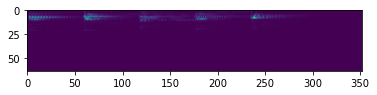

In [178]:
signal, label = usd[2]
usd[0][0].shape # after mel spectogram: torch.Size([1, 64, 352])
plt.imshow(usd[2][0][0])
print(f'Label: {label}')

#Every 30000 one new tone (0.625 seconds), last 30000 does not play anything (0.625 seconds).. 

In [179]:
signal.shape

torch.Size([1, 64, 352])